# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
import json
import sys
sys.path.append('../..')

from utils import validateJson

jsonData = json.load(open('recipes_valid.json'))
#validateJson.validateRecimeJson(jsonData)

print(jsonData.keys())

dict_keys(['title', 'ingredients', 'instructions'])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/'
import sys
sys.path.append(dataPath)

In [ ]:
dataPath = ''

In [1]:
import pickle
import pandas as pd

with open(dataPath + 'recipes_valid.pkl', 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())

Index(['title', 'ingredients', 'instructions'], dtype='object')


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [2]:
data = []

for recipeIndex, item in enumerate(pklData.iterrows()):
    rowData = {}
    for index, ingredient in item[1]['ingredients'].iterrows():
        for key in ingredient.keys():
            rowData[key+str(index)] = ingredient[key]
    data.append(rowData)
    if recipeIndex == 30000:
        break

frame = pd.DataFrame(data)
del data


In [3]:
from sklearn.preprocessing import OneHotEncoder


dropColumns = []
for column in frame.columns:
    if 'amount' in column:
        dropColumns.append(column)
frameStripped = frame.drop(columns=dropColumns)

enc = OneHotEncoder()
enc.fit(frameStripped)
frameStrippedEncodedSki = pd.DataFrame(data=enc.transform(frameStripped).toarray(), columns=enc.get_feature_names(frameStripped.columns))

frameEncodedSki = pd.concat([frame[dropColumns], frameStrippedEncodedSki], axis=1)
del frame
del pklData

## VAE
### Setup

In [4]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from cvae import VariationalAutoEncoder

# Import custom helper functions
from networkUtils import DataBuilder, CustomLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setup Datasets + Hyperparameters

In [5]:
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(frameEncodedSki, train=True)
testdata_set=DataBuilder(frameEncodedSki, train=False)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [6]:
D_in = testdata_set.x.shape[1]
H = 1024
H2 = 128
latent_dim = 32
model = VariationalAutoEncoder(D_in, H, H2, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

### Train Model

In [7]:
epochs = 100
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [9]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [10]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

====> Epoch: 5 Average training loss: 62652.6372
====> Epoch: 5 Average test loss: 57849.9473
====> Epoch: 10 Average training loss: 55094.8420
====> Epoch: 10 Average test loss: 51517.9100


10
10


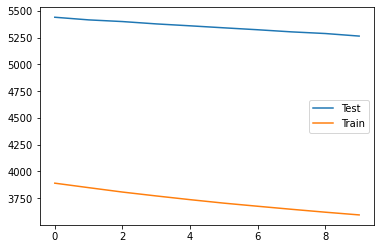

In [ ]:
import matplotlib.pyplot as plt
print(len(test_losses))
print(len(train_losses))
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

In [ ]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [ ]:
scaler = trainloader.dataset.standardizer
recon_row = scaler.inverse_transform(recon_batch[0].cpu().numpy())
real_row = scaler.inverse_transform(testloader.dataset.x[0].cpu().numpy())

In [ ]:
cols = frameEncodedSki.columns
df = pd.DataFrame(np.stack((recon_row, real_row)), columns = cols)
df

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit19_cup,unit19_teaspoon,unit19_nan,ingredient19_almonds,ingredient19_basil,ingredient19_cracked black pepper,ingredient19_cumin seeds,ingredient19_nutmeg,ingredient19_parmesan cheese,ingredient19_nan
0,4069.435547,25.100571,8.384149,35.684978,22.098763,10.890341,22.54446,-2.135371,-11.888251,-27.573385,...,5.137306e-02,-2.228393e-02,1.061128,3.832871e-02,-1.376653e-02,-1.882384e-02,-0.456154,0.045609,-3.007234e-02,1.02141
1,1.999990,8.000000,3.000000,1.000000,1.000000,2.000000,1.00000,1.000002,8.000001,2.000000,...,-3.084925e-12,-3.084925e-12,1.000000,-3.084925e-12,-3.084925e-12,-3.084925e-12,0.000000,0.000000,-3.084925e-12,1.00000


### Draw random samples form latent space and generate new data

In [ ]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [ ]:
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data, columns = cols)
df_fake.head(10)

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit19_cup,unit19_teaspoon,unit19_nan,ingredient19_almonds,ingredient19_basil,ingredient19_cracked black pepper,ingredient19_cumin seeds,ingredient19_nutmeg,ingredient19_parmesan cheese,ingredient19_nan
0,6551.796875,-1.687621,5.096086,-22.782663,-49.666183,-59.545414,-64.094551,-89.957886,-112.402351,-100.477890,...,-0.033748,-0.008588,1.009233,-0.030370,-0.003582,0.040633,-1.147479,-0.381757,-0.000092,0.984637
1,-27859.281250,-1.213871,-26.454327,-60.203640,132.621887,55.331959,50.409863,108.183319,74.722466,46.478752,...,0.015260,-0.011968,1.154680,-0.066346,-0.021211,-0.036967,-0.840336,3.322709,-0.051786,1.186711
2,3646.896973,-1.310707,8.737277,-39.697010,-21.405460,-59.867847,-77.442490,-74.913948,-70.640976,-100.311386,...,0.029477,0.027521,0.928953,0.051870,0.028180,0.022180,-0.713649,-0.009964,0.013870,0.947610
3,7898.404785,16.062279,11.402502,-6.092183,-9.351019,-25.308195,-23.415936,-52.769615,-68.920723,-72.780548,...,0.009297,0.008323,0.954601,0.009336,-0.006710,0.034884,0.419481,-0.650124,-0.001231,0.933214
4,-6240.641113,12.486282,20.613802,73.016373,9.241776,42.396492,28.689632,0.647222,12.004334,-35.859482,...,-0.014204,0.006477,1.082348,-0.020119,0.010698,0.033288,2.054501,-0.647712,-0.048238,1.053902
5,13380.573242,19.158361,69.747543,4.317741,-66.656403,-38.471500,-41.990551,-92.361107,-86.729729,-103.874542,...,-0.001785,-0.013040,0.990167,0.006048,-0.023223,-0.002854,-0.392776,-0.702075,0.037874,0.963221
6,13611.848633,13.786427,28.000645,-9.126018,-38.170444,-38.269596,-40.541916,-70.400948,-80.285210,-85.513161,...,-0.022207,-0.019410,1.065616,-0.027851,-0.022029,0.000477,0.405250,-0.368254,0.005239,1.017390
7,-15315.568359,-60.670094,-43.980202,-30.947723,61.503983,-14.351542,-27.017117,29.329016,-34.378761,-25.422291,...,-0.009142,-0.065576,1.007117,-0.009156,-0.071600,0.058112,1.323053,0.698131,0.061399,1.006603
8,-1690.828613,2.047144,-13.466297,28.406792,28.305481,-4.585693,33.469967,8.997705,-6.575698,-33.032078,...,0.104461,-0.034996,1.029673,0.068809,-0.037472,-0.016615,1.425537,0.089037,-0.039582,1.059141
9,9786.721680,18.132496,48.790100,10.252646,-42.119713,-84.800117,-83.636719,-80.516167,-126.028893,-122.820297,...,-0.000260,0.047563,0.945169,-0.019861,0.045285,0.018218,0.143192,0.198113,-0.004515,0.959610


In [ ]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped.columns)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit15,ingredient15,unit16,ingredient16,unit17,ingredient17,unit18,ingredient18,unit19,ingredient19
0,6551.796875,-1.687621,5.096086,-22.782663,-49.666183,-59.545414,-64.094551,-89.957886,-112.402351,-100.477890,...,NaN,NaN,NaN,heavy cream,NaN,NaN,NaN,NaN,NaN,NaN
1,-27859.281250,-1.213871,-26.454327,-60.203640,132.621887,55.331959,50.409863,108.183319,74.722466,46.478752,...,,salted butter,NaN,brown sugar,NaN,NaN,pound-mass,parsnips,NaN,nutmeg
2,3646.896973,-1.310707,8.737277,-39.697010,-21.405460,-59.867847,-77.442490,-74.913948,-70.640976,-100.311386,...,NaN,fresh parsley,NaN,toasted sesame oil,NaN,rubbed sage,NaN,parsnips,NaN,NaN
3,7898.404785,16.062279,11.402502,-6.092183,-9.351019,-25.308195,-23.415936,-52.769615,-68.920723,-72.780548,...,NaN,dried oregano,NaN,canola oil,NaN,NaN,teaspoon,parsnips,NaN,NaN
4,-6240.641113,12.486282,20.613802,73.016373,9.241776,42.396492,28.689632,0.647222,12.004334,-35.859482,...,NaN,parsley,NaN,chicken broth,NaN,rubbed sage,NaN,NaN,NaN,cumin seeds
5,13380.573242,19.158361,69.747543,4.317741,-66.656403,-38.471500,-41.990551,-92.361107,-86.729729,-103.874542,...,NaN,NaN,NaN,heavy cream,NaN,NaN,NaN,NaN,NaN,NaN
6,13611.848633,13.786427,28.000645,-9.126018,-38.170444,-38.269596,-40.541916,-70.400948,-80.285210,-85.513161,...,NaN,NaN,NaN,NaN,NaN,sherry wine,NaN,NaN,NaN,NaN
7,-15315.568359,-60.670094,-43.980202,-30.947723,61.503983,-14.351542,-27.017117,29.329016,-34.378761,-25.422291,...,NaN,nuts,NaN,canola oil,NaN,apple cider,NaN,NaN,NaN,cumin seeds
8,-1690.828613,2.047144,-13.466297,28.406792,28.305481,-4.585693,33.469967,8.997705,-6.575698,-33.032078,...,NaN,dried oregano,NaN,dried thyme,NaN,NaN,NaN,cooked rice,NaN,cumin seeds
9,9786.721680,18.132496,48.790100,10.252646,-42.119713,-84.800117,-83.636719,-80.516167,-126.028893,-122.820297,...,NaN,NaN,NaN,white wine,NaN,ground cinnamon,NaN,NaN,NaN,NaN


In [ ]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"[6551.796875, , idaho potatoes]","[-1.6876206398010254, , lamb shanks]","[5.096085548400879, centimetre, frozen blueber...","[-22.782663345336914, teaspoon, frozen unsweet...","[-49.66618347167969, , refried beans]","[-59.545413970947266, , Italian - style diced ...","[-64.09455108642578, nan, Pepsi]","[-89.9578857421875, nan, teriyaki marinade]","[-112.40235137939453, nan, ham steaks]","[-100.47789001464844, nan, roasted red peppers]","[-116.57324981689453, nan, mushroom soup]","[-133.0883331298828, nan, frozen broccoli]","[-114.13516998291016, nan, garlic powder]","[-111.1909408569336, nan, blueberries]","[-124.7801742553711, nan, red bell pepper]","[-127.02421569824219, nan, nan]","[-118.05122375488281, nan, heavy cream]","[-97.57659912109375, nan, nan]","[-104.85665130615234, nan, nan]","[-97.79256439208984, nan, nan]"
1,"[-27859.28125, , tofu]","[-1.2138705253601074, cup, lemon, juice of]","[-26.454326629638672, , turmeric]","[-60.20363998413086, , pork fillets]","[132.62188720703125, , pumpkin]","[55.33195877075195, teaspoon, ground mace]","[50.40986251831055, tonne, jicama]","[108.18331909179688, tonne, lime]","[74.72246551513672, pint, brown sugar]","[46.47875213623047, , garbanzo beans]","[48.64813995361328, teaspoon, shredded coconut]","[50.55161666870117, pinch, coarse sugar]","[21.701467514038086, teaspoon, pasta]","[-5.967901706695557, teaspoon, corn husks]","[15.386287689208984, nan, fresh rosemary]","[-31.980199813842773, , salted butter]","[-56.009239196777344, nan, brown sugar]","[-91.64092254638672, nan, nan]","[-97.66059112548828, pound-mass, parsnips]","[-116.10257720947266, nan, nutmeg]"
2,"[3646.89697265625, cup, fresh spinach]","[-1.310706615447998, cup, horseradish sauce]","[8.737277030944824, centimetre, fresh ground p...","[-39.6970100402832, cup, cornmeal]","[-21.405460357666016, teaspoon, ready - to - u...","[-59.86784744262695, tonne, long grain rice]","[-77.44248962402344, litre, fresh jalapenos]","[-74.91394805908203, nan, lemon extract]","[-70.64097595214844, nan, instant espresso pow...","[-100.31138610839844, nan, cilantro leaves]","[-106.13519287109375, nan, garlic salt]","[-81.030029296875, nan, baby clams]","[-89.7620849609375, nan, cornstarch]","[-106.18333435058594, nan, black pepper]","[-64.31040954589844, nan, tomatoes]","[-98.73408508300781, nan, fresh parsley]","[-78.70779418945312, nan, toasted sesame oil]","[-93.29244995117188, nan, rubbed sage]","[-81.24325561523438, nan, parsnips]","[-96.18000793457031, nan, nan]"
3,"[7898.40478515625, cup, Dijon mustard]","[16.062278747558594, litre, bay scallops]","[11.402502059936523, , fresh cilantro leaves]","[-6.092182636260986, quart, simple syrup]","[-9.351018905639648, , pitted black olives]","[-25.308195114135742, , rum]","[-23.415935516357422, litre, lime juice]","[-52.769615173339844, cubic centimetre, prepar...","[-68.92072296142578, nan, wooden skewers]","[-72.78054809570312, nan, red bell pepper]","[-75.70695495605469, nan, confectioners' sugar]","[-99.5121078491211, nan, dill weed]","[-88.20655059814453, nan, egg yolk]","[-91.40618133544922, nan, low - fat sour cream]","[-90.47868347167969, nan, shredded cheddar che...","[-100.05155181884766, nan, dried oregano]","[-91.82037353515625, nan, canola oil]","[-100.63699340820312, nan, nan]","[-86.86548614501953, teaspoon, parsnips]","[-91.41455841064453, nan, nan]"
4,"[-6240.64111328125, tablespoon, agave syrup]","[12.486282348632812, nan, thousand island dres...","[20.613801956176758, , goat cheese]","[73.01637268066406, quart, corn oil]","[9.241776466369629, cup, minced ginger]","[42.39649200439453, quart, cloves]","[28.689632415771484, litre, spinach]","[0.647222101688385, tonne, Kraft Grated Parmes...","[12.004334449768066, teaspoon, mustard powder]","[-35.85948181152344, nan, pumpernickel bread]","[-56.70491027832031, nan, bacon]","[-29.626436233520508, pint, cayenne pepper]","[-81.23491668701172, nan, lamb]","[-76.2158889770507